# qsample
Efficient sampling of noisy quantum circuits and protocols

* Docs: https://dpwinter.github.io/qsample/

In [ ]:
#| include: false
import matplotlib.pyplot as plt
import numpy as np

## Install

At the moment only build from source available:
```
git clone https://github.com/dpwinter/qsample.git
cd qsample
python setup.py install
```

## Prerequisites 

* This package requires Python 3.8 or higher.   
* pdflatex (for circuit rendering)  

## When to use

qsample offers efficient and fast estimation of logical failure rates of quantum error correction protocols when the fidelity of physical operations in the quantum circuits is high, such as in expertimental implementations today. 

This package is for you if you want to
* model circuit-level incoherent Pauli noise (we don't do coherent noise here, neither are our auxiliary qubits modelled as ideal) 
* with high fidelity physical operations aka low physical error rates
* for a QEC protocol that consists of execution of one or more quantum circuits with in-sequence measurements and feed-forward of measurement information
* over a specific range of varying physical error rates

It currently offers to
* build quantum circuits from the standard quantum gates: H, X, Z, CNOT
* run stabilizer simulations with a standard CHP backend
* model multiparameter noise with distinct error rates for single- and two-qubit gates: p1, p2
* estimate logical failure rates until uncertainty is lower than a given target confidence interval
* choose direct Monte Carlo or Subset Sampling as sampling method

Background information:

The predominant method to model incoherent Pauli noise in quantum circuits is direct Monte Carlo (MC) sampling. MC is very inefficient for low physical error rates since most of the time no actual fault event is realized in simulation. Subset sampling circumvents this issue. With this method, presented in \cite{DSS}, fault events are categorized into distinct subsets which contribute to a polynomial sum expansion of the logical failure rate. In subset sampling, only the subsets that contribute most to the logical failure rate are actually estimated via sampling -- rendering it an importance sampling technique. Both the sampling variance and the uncertainty from ignored, i.e. non-sampled, subsets stay well-defined and can be held small throughout the sampling procedure.

## Getting started
---

### Library overview
1. Circuit
2. Protocol
3. Error Model
4. Simulator
5. Sampler    
    5.1. Direct Sampler  
    5.2. Interlude: Callbacks  
    5.3. Subset Sampler  

### 1. Circuit 
* List of ticks
* Each tick is a dictionary, key: gate type, value: set of qubit(s)
* Recommended: 1 gate type per tick

**Example:** Flagged-GHZ preparation:
* Produce GHZ state on qubits 0-3
* Flag-qubit 4, measure:
    * 0: error-free*
    * 1: flip on one data qubit*

\* Only for max. 1 allowed fault.

In [ ]:
from qsample import Circuit

In [ ]:
ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}], ff_det=True)

**ff_det**: fault-free deterministic. Set to `True` if circuit gives unique measurement result when executed without faults.

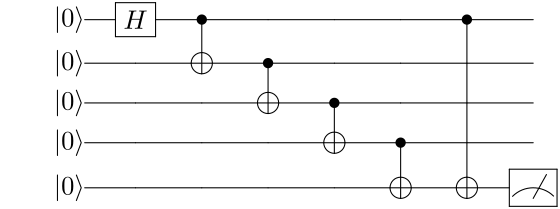

In [ ]:
ghz.draw()

### 2. Protocol

* Graph (can be cyclic)
    * Vertices: Circuits
    * Edges: transition rules = boolean\* functions (*checks*)
    * Must include **start** and **end** nodes.  
    
\* Exception: Correction functions can return circuits for on-the-fly execution. (special case, will not show here)

**Example:** Flagged-GHZ repeat(3)-until-success
* Execute flagged-GHZ circuit max. 3 times.
* Only repeat if measured `1`.
* If measured flag to be `0` within 3 iteration -> No fail
* If after 2 iterations 3rd measurement is also `1` -> Fail

In [ ]:
from qsample import Protocol

In [ ]:
ghz3 = Protocol(fault_tolerant=True)

ghz3.add_node('ghz', circuit=ghz) # Add node with corresponding circuit
ghz3.add_edge('START', 'ghz', check='True') # Transition START -> first circuit node always True
ghz3.add_edge('ghz', 'ghz', check='repeat(ghz)') # Transition to ghz if repeat(ghz) True.
ghz3.add_edge('ghz', 'FAIL', check='logErr(ghz)') # Transition to final node FAIL if logErr(ghz) True.

**fault_tolerant:** Define all weight-1 paths (circuit sequence with max. 1 fault) to never result in a logical fail.

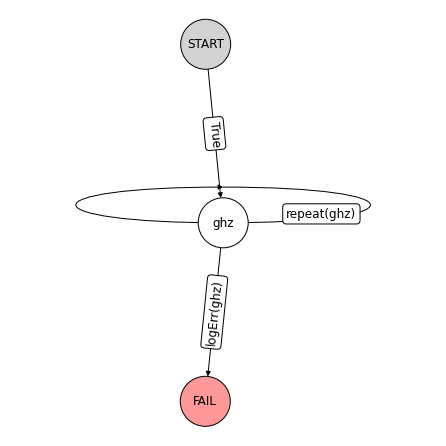

In [ ]:
ghz3.draw()

* `repeat()` and `logErr()` are user-defined (boolean) check functions
* Measurement history of circuits stored during for protocol run
    * Can access measurement history of any circuit by passing its name as argument  
    
Next, we define what the two check functions should do:

In [ ]:
def repeat(msmt_list): # arg: list of ghz's measurment history
    return len(msmt_list) < 3 and msmt_list[-1] == 1 # If True repeat ghz

def logErr(msmt_list):
    return len(msmt_list) == 3 and msmt_list[-1] == 1 # If True transition to `FAIL`

functions = {'logErr': logErr, 'repeat': repeat}
ghz3._check_fns.update(functions) # Let protocol know about user-defined checks

**Note**: It is also possible that **all checks are false**. In this case the protocol exits "insignficantly".  
Here: "insignificant" when Flag=0 within 3 protocol runs -> Go to next protocol run, i.e. sample.

### 3. Error model
* Strategy:
    * Generate *fault* circuit $C_f$ of same length as reference circuit $C$
    * During simulation iterate $C$ and $C_f$ simulateously and apply to state
* Must include:
    * `group()`: group circuit locations by key, e.g. all 1-qubit-gates
    * `select()`: picks certain amount of locations from each group (not required by user)
    * `generate()`: generator function, returns a Pauli fault operator for given location

In [ ]:
from qsample import E1

E1.groups, E1().group(ghz) # All gates in group `q`

(['q'],
 {'q': [(1, 0),
   (2, (0, 1)),
   (3, (1, 2)),
   (4, (2, 3)),
   (5, (3, 4)),
   (6, (0, 4))]})

### 4. Simulator
* Two types available: Stabilizer (CHP) and Statevectors (ProjectQ port), both well-tested
    * https://github.com/Strilanc/python-chp-stabilizer-simulator
    * https://github.com/ProjectQ-Framework/ProjectQ
* Statevector simulator has more available gates and functions

In [ ]:
from qsample import StabilizerSimulator as CHP

### 5. Sampler
* Two types: Direct (Monte Carlo) and Subset sampler
* All relevant information stored in `CountTree` data structure

### 5.1. Direct sampler

In [ ]:
from qsample import DirectSampler
import numpy as np
import matplotlib.pyplot as plt

Let's define some physical error rates at which to sample:

In [ ]:
sample_range = np.logspace(-3,0,5)
err_probs = {'q': sample_range} # Note: Must provide rate(s) for each group specified in `ErrorModel`
err_probs

{'q': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])}

In [ ]:
dsam = DirectSampler(protocol=ghz3, simulator=CHP, err_probs=err_probs, err_model=E1)
dsam.run(10000)

p_phy=1.00E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=5.62E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=3.16E-02:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=1.78E-01:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=1.00E+00:   0%|          | 0/10000 [00:00<?, ?it/s]

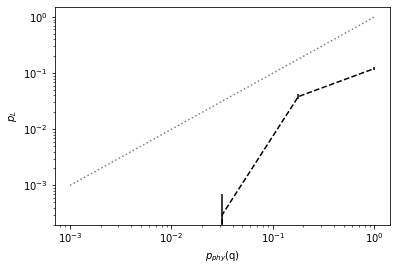

In [ ]:
p_L, std = dsam.stats()

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.plot(sample_range, sample_range,'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{phy}$(q)')
plt.ylabel('$p_L$');

Check what has been sampled for the last (1e0) physical error rate:

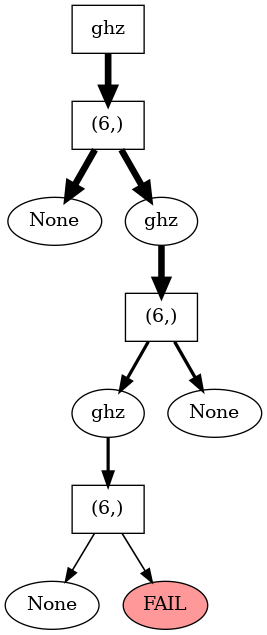

In [ ]:
dsam.trees[(1.0,)].draw()

### 5.2. Interlude: Callbacks
* Used to receive intermediate results inside sampling process
* E.g. we might want to avoid unnecessary samples (at large $p_{phy}$)
    * We can use the callback `RelStdTarget`

In [ ]:
from qsample import callbacks as cb

dsam2 = DirectSampler(protocol=ghz3, simulator=CHP, err_probs=err_probs, err_model=E1)
dsam2.run(10000, callbacks=[cb.RelStdTarget(target=0.2)])

p_phy=1.00E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=5.62E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=3.16E-02:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=1.78E-01:   0%|          | 0/10000 [00:00<?, ?it/s]

Rel. std target of 0.2 reached. Sampling stopped.


p_phy=1.00E+00:   0%|          | 0/10000 [00:00<?, ?it/s]

Rel. std target of 0.2 reached. Sampling stopped.


Another callback is `VerboseCircuitExec`, which gives a detailed log of which circuits, faults and measurements took place:

In [ ]:
dsam3 = DirectSampler(protocol=ghz3, simulator=CHP, err_probs={'q': 0.1}, err_model=E1)
dsam3.run(10, callbacks=[cb.VerboseCircuitExec()])

p_phy=1.00E-01:   0%|          | 0/10 [00:00<?, ?it/s]

ghz -> Faults: [] -> Msmt: 0
None
ghz -> Faults: [] -> Msmt: 0
None
ghz -> Faults: [(6, {'Y': {0}})] -> Msmt: 0
None
ghz -> Faults: [] -> Msmt: 0
None
ghz -> Faults: [(4, {'Z': {2}})] -> Msmt: 0
None
ghz -> Faults: [(1, {'Z': {0}})] -> Msmt: 0
None
ghz -> Faults: [] -> Msmt: 0
None
ghz -> Faults: [] -> Msmt: 0
None
ghz -> Faults: [(4, {'X': {2}})] -> Msmt: 0
None
ghz -> Faults: [(2, {'Y': {0}, 'Z': {1}}), (5, {'Z': {3}})] -> Msmt: 1
ghz -> Faults: [] -> Msmt: 0
None


We can also write our own callback. Every sampler has 6 callback hooks:
* Begin/End sampler
* Begin/End protocol
* Begin/End circuit

### 5.3. Subset Sampler
* Samples only at one physical error rate `pmax`
* Scaling obtained analytically
* `pmax` must be chosen in "representative" region

*Note*:
1. For multi-parameter error model `pmax` is a tuple of one physical error rate per group.
2. The choice of `pmax` has a direct impact of which subsets are sampled.

How to choose `pmax`? What is the heuristic?
* We want to sample, s.t. the subset occurence probability is max. for 0-weight subset and subsequently falling for higher order subsets.
* We want to have also relatively high probability for other (important) subsets, i.e. weight-1, weight-2,..

**Example:** For the Flagged-GHZ circuit we would choose a `pmax` close to 0.1:

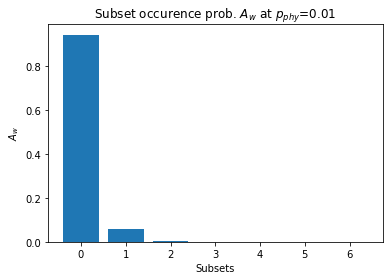

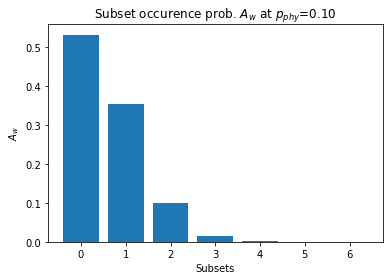

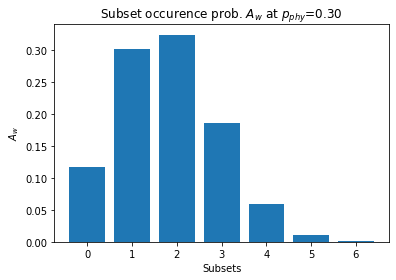

In [ ]:
from qsample.sampler.base import subset_occurence, all_subsets, err_probs_tomatrix

grp = E1().group(ghz).values()
wgts_combis = all_subsets(grp)

for p_phy in [0.01, 0.1, 0.3]:
    Aws = subset_occurence(grp, wgts_combis, p_phy)
    plt.figure()
    plt.title("Subset occurence prob. $A_w$ at $p_{phy}$=%.2f" % p_phy)
    plt.bar(range(len(Aws)), Aws)
    plt.ylabel("$A_w$")
    plt.xlabel("Subsets")

In [ ]:
from qsample import SubsetSampler

In [ ]:
pmax = {'q': 0.1}

ss_sam = SubsetSampler(ghz3, CHP,  pmax=pmax, err_probs=err_probs, err_model=E1)
ss_sam.run(300)

p_phy=1.00E-01:   0%|          | 0/300 [00:00<?, ?it/s]

*Note*: Although we passed `err_probs` those are not used for sampling. Only when we call `stats()` those probs are used:

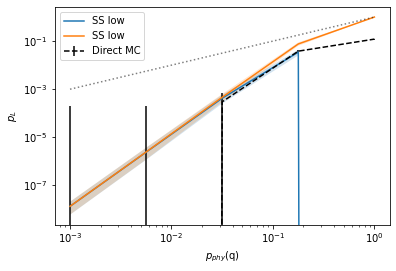

In [ ]:
p_L_low, std_low, p_L_up, std_up = ss_sam.stats()

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.loglog(sample_range, p_L_low, label='SS low')
plt.fill_between(sample_range, p_L_low - std_low, p_L_low + std_low, alpha=0.2)
plt.loglog(sample_range, p_L_up, label='SS low')
plt.fill_between(sample_range, p_L_up - std_up, p_L_up + std_up, alpha=0.2)
plt.plot(sample_range, sample_range,'k:', alpha=0.5)
plt.xlabel('$p_{phy}$(q)')
plt.ylabel('$p_L$')
plt.legend();

We sampled at a single error rate with much less samples and get a much better bound on the logical error rate. Let's inspect what has been sampled:

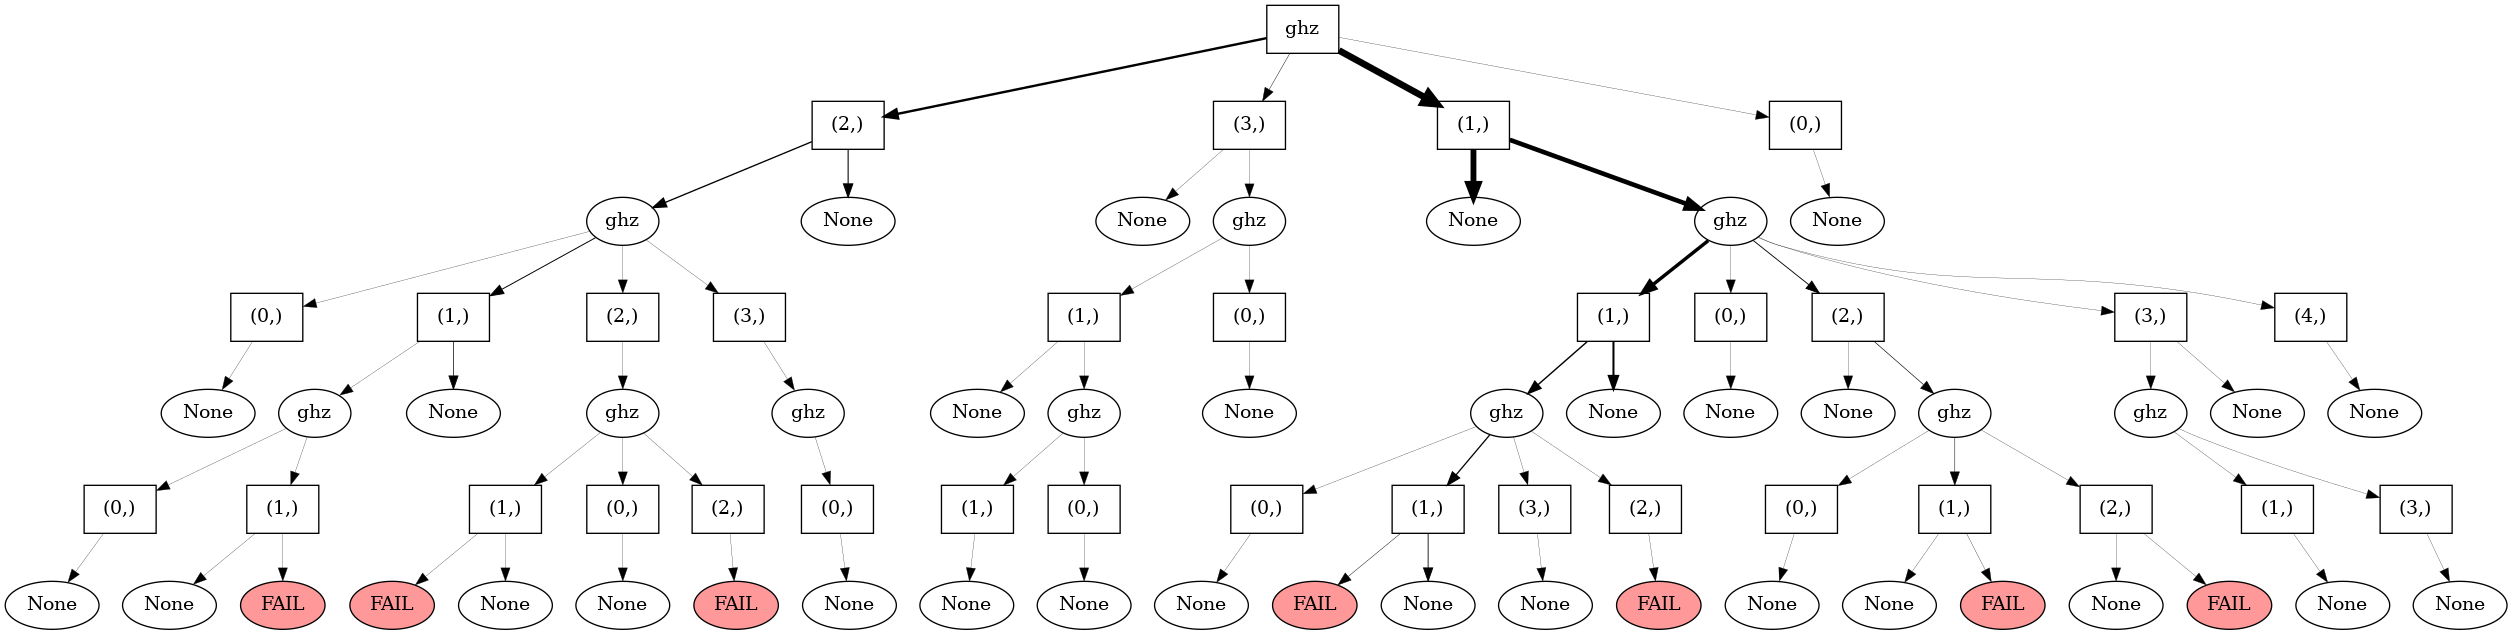

In [ ]:
ss_sam.tree.draw() # only one tree

We can store and later reload our sample results:

In [ ]:
ss_sam.save('ghz3ss.samp')

from qsample import Sampler
stored_sam = Sampler.load('ghz3ss.samp')
counts_before = stored_sam.tree.root.counts

stored_sam.run(200) # After loading we can for example run a few more samples.
counts_after = stored_sam.tree.root.counts

print(counts_before, counts_after)

p_phy=1.00E-01:   0%|          | 0/200 [00:00<?, ?it/s]

300 500


More complex examples can be found here: https://github.com/dpwinter/qsample/blob/master/08_examples.ipynb

## Contribute 

* submit your feature request via github issue

## Team 

`qsample` was developed by Don Winter based on \cite{DSS} and in collaboration with Sascha Heußen under supervision of Prof. Dr. Markus Müller.